### Initializing the libraries

In [65]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numba import jit
from multiprocessing import Pool, cpu_count
import dask.array as da
from dask import delayed
from dask.distributed import Client, LocalCluster

### 1.1 Naive approach

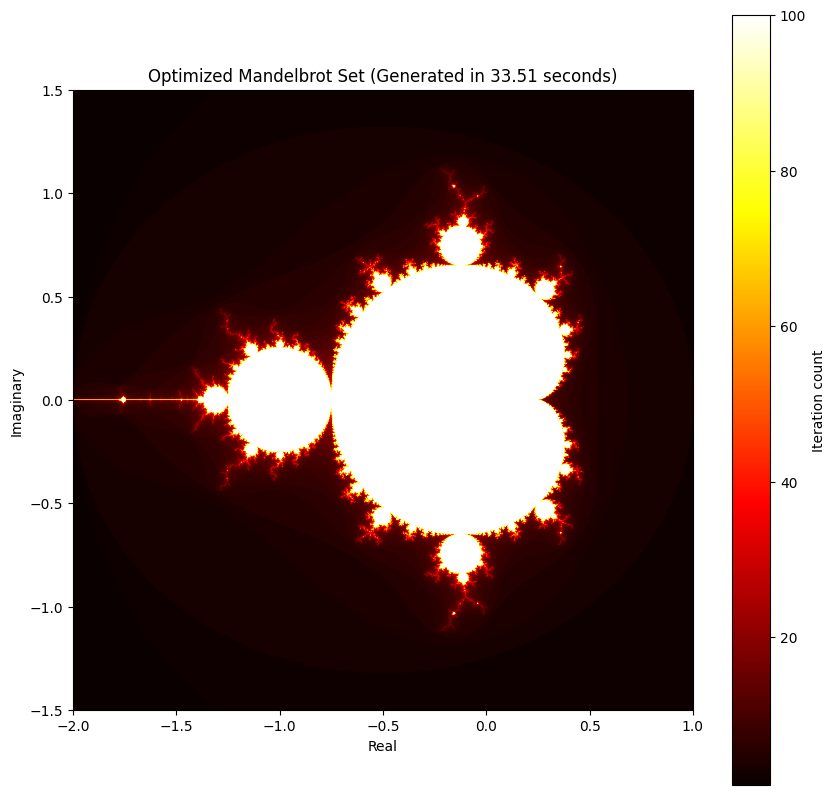

Execution time (optimized approach): 33.51 seconds


In [4]:
def mandelbrot(c_real, c_imag, max_iterations):

    """
        It calculates the number of iterations for a given complex number c.

        Parameters:
            c_real (np.float32): The real part of the complex number c.
            c_imag (np.float32): The imaginary part of the complex number c.
            max_iterations (int): Maximum number of iterations for the Mandelbrot set calculation.

        Returns:
            int: Number of iterations taken for the given complex number to escape.
    """


    z_real, z_imag = np.float32(0), np.float32(0)
    
    for n in range(max_iterations):
        # Calculating the magnitude squared of z
        mag_squared = z_real*z_real + z_imag*z_imag
        if mag_squared > np.float32(4):
            return n
        # Updating z using the Mandelbrot formula
        z_real_new = z_real*z_real - z_imag*z_imag + c_real
        z_imag = np.float32(2) * z_real * z_imag + c_imag
        z_real = z_real_new
        
    return max_iterations

def generate_mandelbrot(width, height, xmin, xmax, ymin, ymax, max_iterations):

    """
        It generates the Mandelbrot set for a given width, height, and region.

        Parameters:
            width (int): Width of the image.
            height (int): Height of the image.
            xmin (np.float32): Minimum value of the real part of the region.
            xmax (np.float32): Maximum value of the real part of the region.
            ymin (np.float32): Minimum value of the imaginary part of the region.
            ymax (np.float32): Maximum value of the imaginary part of the region.
            max_iterations (int): Maximum number of iterations for the Mandelbrot set calculation.

        Returns:
            list: 2D list representing the Mandelbrot set.
    """
    
    mandelbrot_set = []

    real_step = (xmax - xmin) / width
    imag_step = (ymax - ymin) / height

    for i in range(height):
        row = []
        for j in range(width):
            real = xmin + j * real_step
            imaginary = ymin + i * imag_step
            row.append(mandelbrot(np.float32(real), np.float32(imaginary), max_iterations))
        mandelbrot_set.append(row)

    return mandelbrot_set

# Parameters
width, height = 1000, 1000
x_min, x_max = np.float32(-2.0), np.float32(1.0)
y_min, y_max = np.float32(-1.5), np.float32(1.5)
max_iterations = 100

# Execution
start_time = time.time()
mandelbrot_set = generate_mandelbrot(width, height, x_min, x_max, y_min, y_max, max_iterations)
end_time = time.time()
execution_time = end_time - start_time

# Plotting
plt.figure(figsize=(10, 10))
plt.imshow(mandelbrot_set, extent=(x_min, x_max, y_min, y_max), cmap='hot', origin='lower')
plt.colorbar(label='Iteration count')
plt.title(f'Optimized Mandelbrot Set (Generated in {execution_time:.2f} seconds)')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()

print(f"Execution time (optimized approach): {execution_time:.2f} seconds")


My previous mandelbrot naive approach was taking 3.28 seconds but when I convert it to float32 then it's taking more than the previous version and I really don't know why this is happening.

### 1.2 Numpy approach

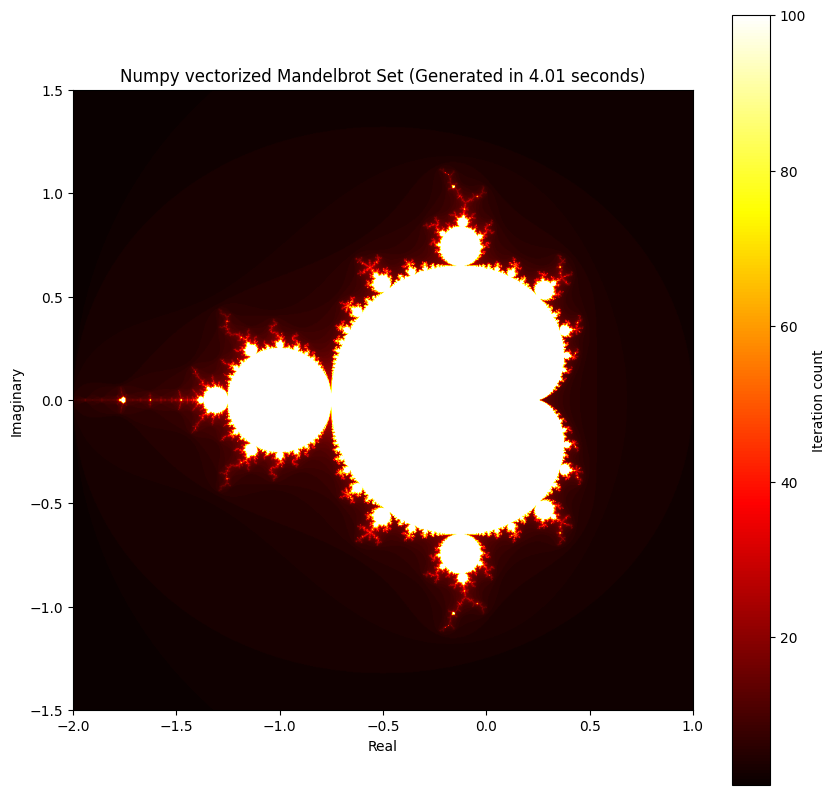

In [22]:
def mandelbrot(c, max_iterations):
    z = 0
    for n in range(max_iterations):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iterations

def generate_mandelbrot(width, height, xmin, xmax, ymin, ymax, max_iterations):
    real = np.linspace(xmin, xmax, width)
    imag = np.linspace(ymin, ymax, height)

    # mandelbrot_set = np.zeros((height, width), dtype=np.float32) # Execution time 4.08 sec
    # mandelbrot_set = np.zeros((height, width), dtype=np.float16) # Execution time 3.85 sec
    # mandelbrot_set = np.zeros((height, width), dtype=np.int32) # Execution time 4.23 sec
    mandelbrot_set = np.zeros((height, width), dtype=np.int16) # Execution time 4.01 sec


    for i in range(height):
        for j in range(width):
            c = complex(real[j], imag[i])
            mandelbrot_set[i, j] = mandelbrot(c, max_iterations)

    return mandelbrot_set

width, height = 1000, 1000
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5
max_iterations = 100

start_time = time.time()
mandelbrot_set = generate_mandelbrot(width, height, x_min, x_max, y_min, y_max, max_iterations)
end_time = time.time()
execution_time = end_time - start_time

plt.figure(figsize=(10, 10))
plt.imshow(mandelbrot_set, extent=(x_min, x_max, y_min, y_max), cmap= 'hot', origin='lower')
plt.colorbar(label='Iteration count')
plt.title(f'Numpy vectorized Mandelbrot Set (Generated in {execution_time:.2f} seconds)')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()


My previous numpy mandelbrot was taking 4.28 seconds where float32 optimized version is taking 4.08 sec, float16 is taking 3.85 sec, int32 is taking 4.23 sec and int16 is taking 4.01 sec

### 1.3 Numba approach

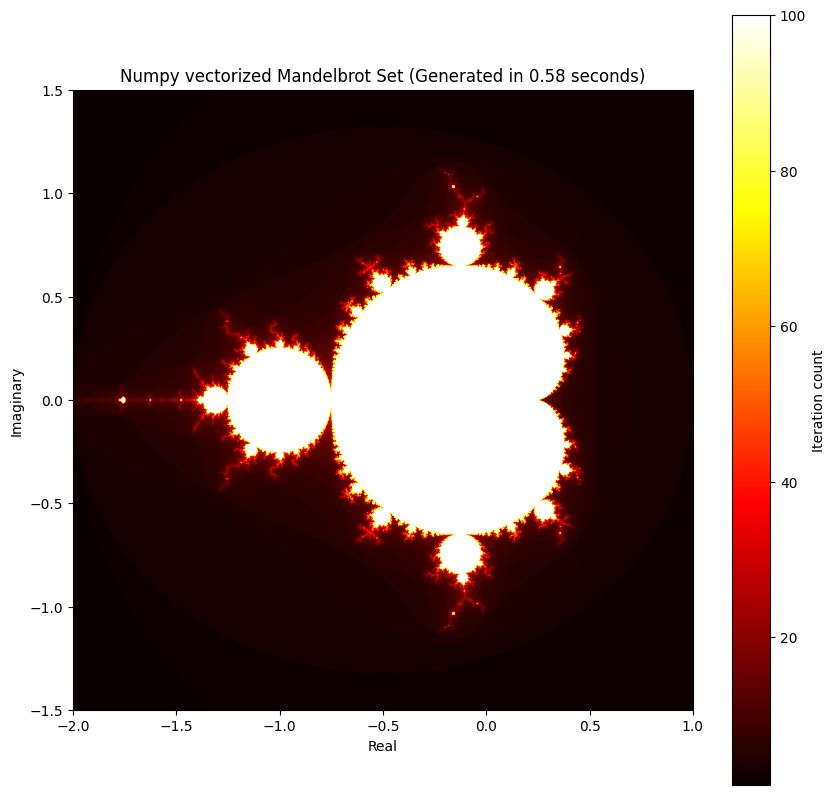

In [35]:
@jit(nopython=True)
def mandelbrot(c, max_iterations):
    z = 0
    for n in range(max_iterations):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iterations

@jit(nopython=True)
def generate_mandelbrot(width, height, xmin, xmax, ymin, ymax, max_iterations):
    real = np.linspace(xmin, xmax, width)
    imag = np.linspace(ymin, ymax, height)

    # mandelbrot_set = np.zeros((height, width), dtype=np.int64) # Execution time 0.61 sec
    # mandelbrot_set = np.zeros((height, width), dtype=np.float64) # Execution time 0.58 sec
    # mandelbrot_set = np.zeros((height, width), dtype=np.float32) # Execution time 0.74 sec
    # mandelbrot_set = np.zeros((height, width), dtype=np.int32) # Execution time 0.60 sec
    mandelbrot_set = np.zeros((height, width), dtype=np.int16) # Execution time 0.58 sec
    



    for i in range(height):
        for j in range(width):
            c = complex(real[j], imag[i])
            mandelbrot_set[i, j] = mandelbrot(c, max_iterations)

    return mandelbrot_set

width, height = 1000, 1000
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5
max_iterations = 100

start_time = time.time()
mandelbrot_set = generate_mandelbrot(width, height, x_min, x_max, y_min, y_max, max_iterations)
end_time = time.time()
execution_time = end_time - start_time

plt.figure(figsize=(10, 10))
plt.imshow(mandelbrot_set, extent=(x_min, x_max, y_min, y_max), cmap= 'hot', origin='lower')
plt.colorbar(label='Iteration count')
plt.title(f'Numpy vectorized Mandelbrot Set (Generated in {execution_time:.2f} seconds)')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()


My previous numba mandelbrot was taking 1.13 seconds where now float64 is taking 0.58 seconds, float32 is taking 0.74 sec, int64 is taking 0.61 sec, int32 is taking 0.60 sec, int16 is taking 0.58 sec

### 1.4 Multiprocessing approach for different chunk sizes

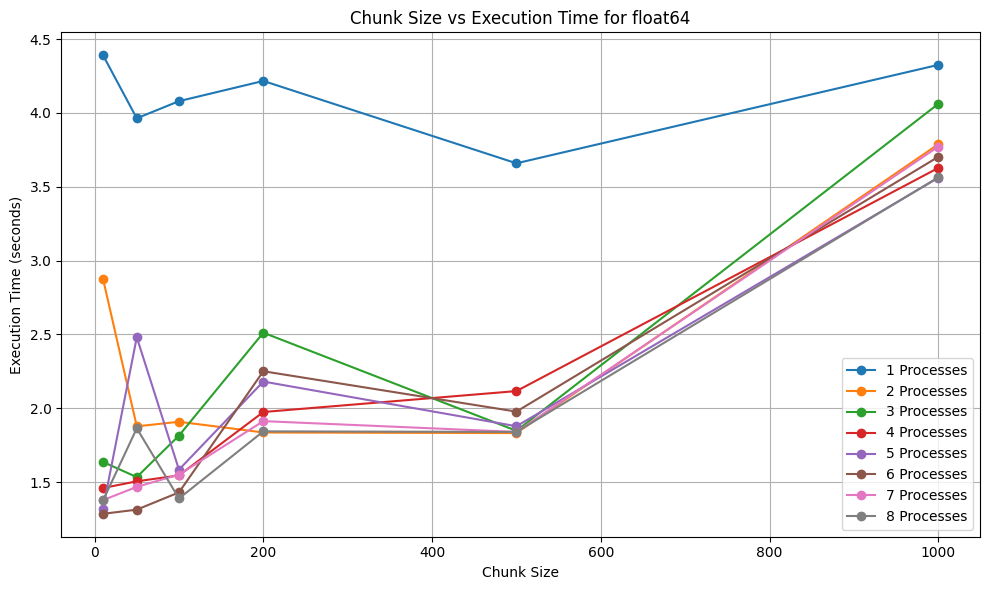

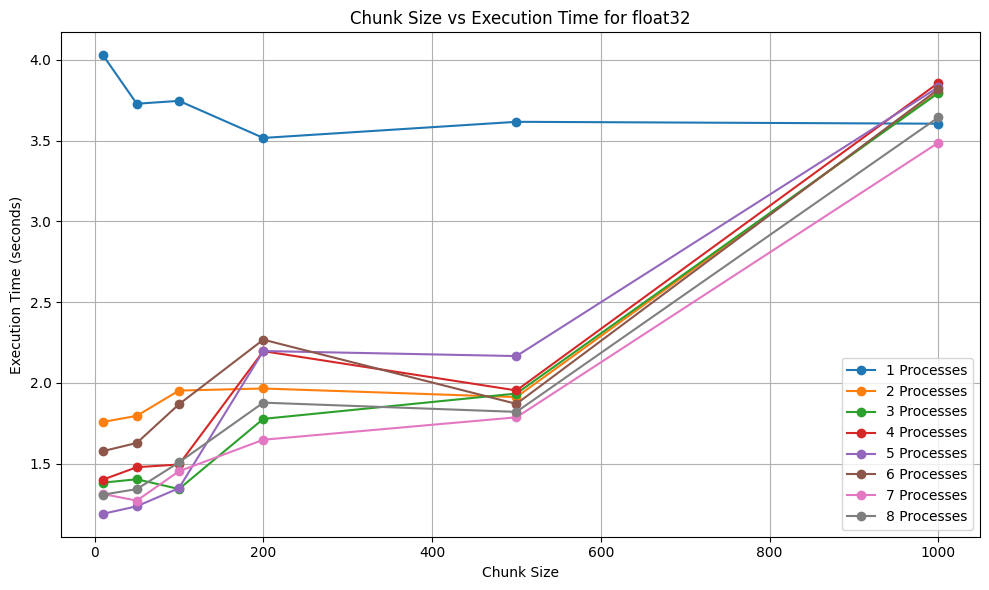

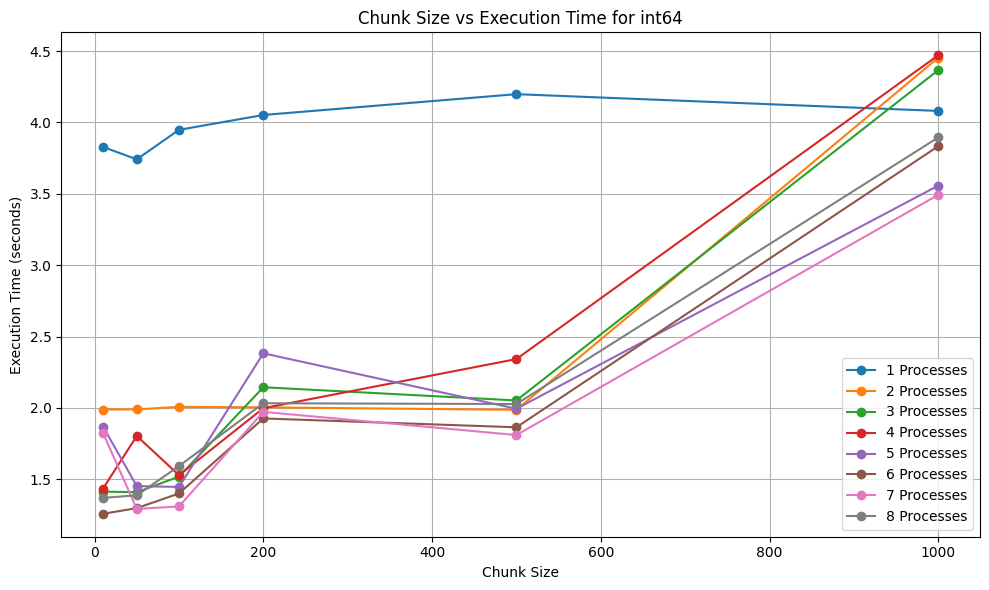

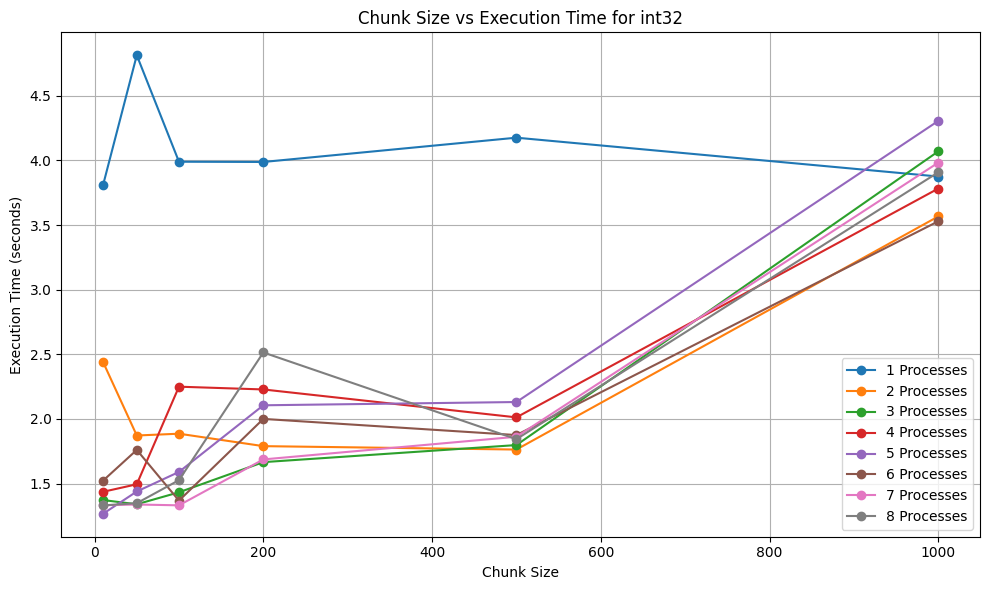

In [41]:
def mandelbrot(c, max_iterations):
    z = 0
    for n in range(max_iterations):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iterations

def compute_mandelbrot_row(args):
    row_idx, width, height, xmin, xmax, ymin, ymax, max_iterations, dtype = args
    row = np.zeros(width, dtype=dtype)
    for j in range(width):
        real = xmin + j * (xmax - xmin) / (width - 1)
        imag = ymin + row_idx * (ymax - ymin) / (height - 1)
        c = complex(real, imag)
        row[j] = mandelbrot(c, max_iterations)
    return row

def generate_mandelbrot_parallel(args):
    num_processes, chunk_size, dtype = args
    pool = Pool(processes=num_processes)
    args_list = [(i, width, height, x_min, x_max, y_min, y_max, max_iterations, dtype) for i in range(height)]
    mandelbrot_rows = pool.map(compute_mandelbrot_row, args_list, chunksize=chunk_size)
    pool.close()
    pool.join()
    mandelbrot_set = np.array(mandelbrot_rows)
    return mandelbrot_set

if __name__ == "__main__":
    width, height = 1000, 1000
    x_min, x_max = -2.0, 1.0
    y_min, y_max = -1.5, 1.5
    max_iterations = 100
    num_processes_list = [1, 2, 3, 4, 5, 6, 7, 8]
    chunk_size_list = [10, 50, 100, 200, 500, 1000]
    dtype_list = [np.float64, np.float32, np.int64, np.int32]

    for dtype in dtype_list:
        execution_times = {num_processes: {chunk_size: None for chunk_size in chunk_size_list} for num_processes in num_processes_list}

        for num_processes in num_processes_list:
            for chunk_size in chunk_size_list:
                start_time = time.time()
                _ = generate_mandelbrot_parallel((num_processes, chunk_size, dtype))
                end_time = time.time()
                execution_time = end_time - start_time
                execution_times[num_processes][chunk_size] = execution_time
                
        # Plotting the graph
        plt.figure(figsize=(10, 6))
        for num_processes in num_processes_list:
            plt.plot(chunk_size_list, [execution_times[num_processes][chunk_size] for chunk_size in chunk_size_list], marker='o', label=f"{num_processes} Processes")

        plt.title(f'Chunk Size vs Execution Time for {dtype.__name__}')
        plt.xlabel('Chunk Size')
        plt.ylabel('Execution Time (seconds)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        # Display the plot
        plt.show()


### 2.1 Dask version of numpy vectorized version

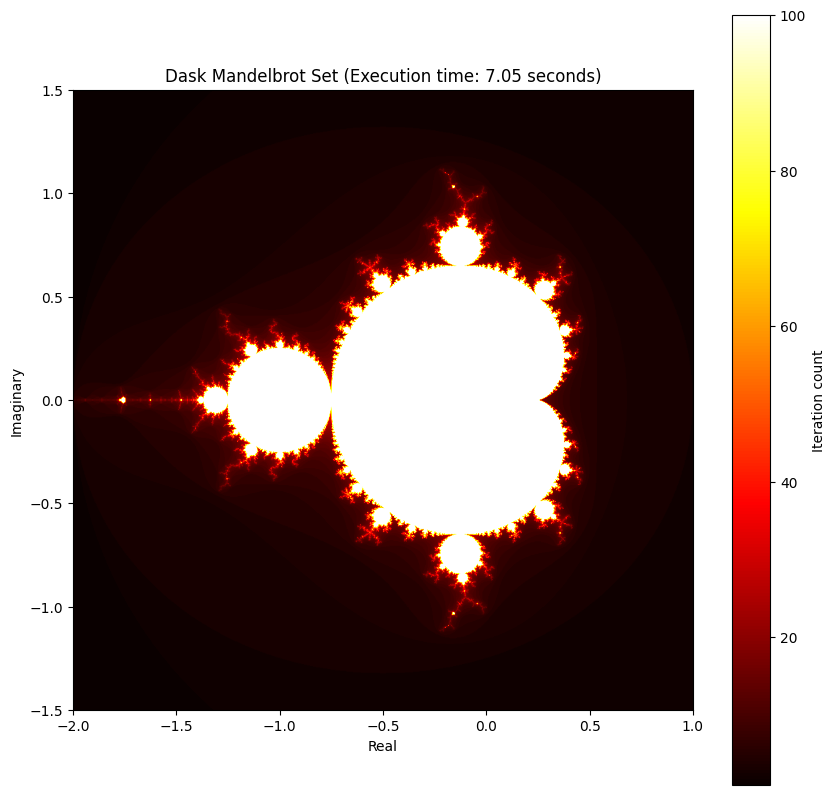

In [73]:
def mandelbrot(c, max_iterations):
    z = 0
    for n in range(max_iterations):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iterations

def compute_mandelbrot_row(args):
    row_idx, width, height, xmin, xmax, ymin, ymax, max_iterations = args
    row = np.zeros(width, dtype=np.int16)
    for j in range(width):
        real = xmin + j * (xmax - xmin) / (width - 1)
        imag = ymin + row_idx * (ymax - ymin) / (height - 1)
        c = complex(real, imag)
        row[j] = mandelbrot(c, max_iterations)
    return row

def generate_mandelbrot_dask(width, height, xmin, xmax, ymin, ymax, max_iterations, chunk_size=None):
    delayed_rows = []
    for i in range(height):
        row = delayed(compute_mandelbrot_row)((i, width, height, xmin, xmax, ymin, ymax, max_iterations))
        delayed_rows.append(row)
    
    # Convert delayed objects to Dask arrays
    dask_arrays = [da.from_delayed(delayed_row, shape=(width,), dtype=np.float64) for delayed_row in delayed_rows]
    
    # Stack Dask arrays along the first axis
    mandelbrot_set = da.stack(dask_arrays)

    # Rechunk the Dask array with specified chunk size
    if chunk_size:
        mandelbrot_set = mandelbrot_set.rechunk(chunk_size)

    return mandelbrot_set



width, height = 1000, 1000
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5
max_iterations = 100

start_time = time.time()
chunk_size = (1000, 1000)
mandelbrot_set_dask = generate_mandelbrot_dask(width, height, x_min, x_max, y_min, y_max, max_iterations, chunk_size=chunk_size)
mandelbrot_set_dask = mandelbrot_set_dask.compute()  # Computing the Dask array
end_time = time.time()
execution_time_dask = end_time - start_time

plt.figure(figsize=(10, 10))
plt.imshow(mandelbrot_set_dask, extent=(x_min, x_max, y_min, y_max), cmap='hot', origin='lower')
plt.colorbar(label='Iteration count')
plt.title(f'Dask Mandelbrot Set (Execution time: {execution_time_dask:.2f} seconds)')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()


### 2.2 Dask cluster execution

/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44203 instead
  warnings.warn(


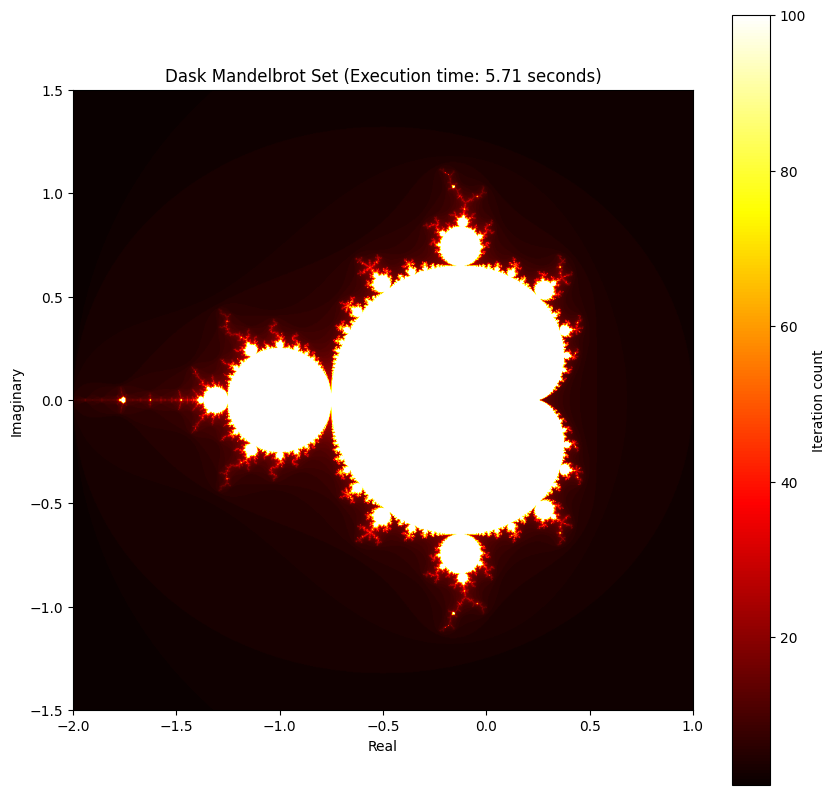

In [69]:
cluster = LocalCluster()
client = Client(cluster)

def mandelbrot(c, max_iterations):
    z = 0
    for n in range(max_iterations):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iterations

def compute_mandelbrot_row(args):
    row_idx, width, height, xmin, xmax, ymin, ymax, max_iterations = args
    row = np.zeros(width, dtype=np.int16)
    for j in range(width):
        real = xmin + j * (xmax - xmin) / (width - 1)
        imag = ymin + row_idx * (ymax - ymin) / (height - 1)
        c = complex(real, imag)
        row[j] = mandelbrot(c, max_iterations)
    return row

def generate_mandelbrot_dask(width, height, xmin, xmax, ymin, ymax, max_iterations):
    # real = np.linspace(xmin, xmax, width)
    # imag = np.linspace(ymin, ymax, height)

    delayed_rows = []
    for i in range(height):
        row = delayed(compute_mandelbrot_row)((i, width, height, xmin, xmax, ymin, ymax, max_iterations))
        delayed_rows.append(row)
    
    # Convert delayed objects to Dask arrays
    dask_arrays = [da.from_delayed(delayed_row, shape=(width,), dtype=np.float64) for delayed_row in delayed_rows]
    
    # Stack Dask arrays along the first axis
    mandelbrot_set = da.stack(dask_arrays)
    return mandelbrot_set

width, height = 1000, 1000
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5
max_iterations = 100

start_time = time.time()
mandelbrot_set_dask = generate_mandelbrot_dask(width, height, x_min, x_max, y_min, y_max, max_iterations)
mandelbrot_set_dask = mandelbrot_set_dask.compute()  # Computing the Dask array
end_time = time.time()
execution_time_dask = end_time - start_time

plt.figure(figsize=(10, 10))
plt.imshow(mandelbrot_set_dask, extent=(x_min, x_max, y_min, y_max), cmap='hot', origin='lower')
plt.colorbar(label='Iteration count')
plt.title(f'Dask Mandelbrot Set (Execution time: {execution_time_dask:.2f} seconds)')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()